# Adapted from [Dive into Deep Learning](https://d2l.ai/index.html), Chapter 13, Section 11. The authors are prominent Amazon data scientists, so they work primarily with the [MXNet](https://mxnet.apache.org/versions/1.7.0/) framework rather than [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/). As such, this assignment will rely on MXNet as well. 

## If running this notebook in Google Colab, mount your Google Drive 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

## If running this notebook in Colab, make sure to navigate to Runtime > Change runtime type, select GPU in the Hardware accelerator drop-down menu, and click Save *before* running the following code cell! Otherwise, `mxnet-cu101` won't install.

In [2]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0

     |████████████████████████████████| 61 kB 3.4 MB/s 
     |███████████████████████████████▌| 834.1 MB 1.2 MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x560f1a2ac000 @  0x7f4bc8e10615 0x560ee10094cc 0x560ee10e947a 0x560ee100c2ed 0x560ee10fde1d 0x560ee107fe99 0x560ee107a9ee 0x560ee100dbda 0x560ee107fd00 0x560ee107a9ee 0x560ee100dbda 0x560ee107c737 0x560ee10fec66 0x560ee107bdaf 0x560ee10fec66 0x560ee107bdaf 0x560ee10fec66 0x560ee107bdaf 0x560ee100e039 0x560ee1051409 0x560ee100cc52 0x560ee107fc25 0x560ee107a9ee 0x560ee100dbda 0x560ee107c737 0x560ee107a9ee 0x560ee100dbda 0x560ee107b915 0x560ee100dafa 0x560ee107bc0d 0x560ee107a9ee
     |████████████████████████████████| 846.0 MB 20 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Fully Convolutional Networks (FCN)
:label:`sec_fcn`

We previously discussed semantic segmentation using each pixel in an image for
category prediction. A fully convolutional network (FCN)
:cite:`Long.Shelhamer.Darrell.2015` uses a convolutional neural network to
transform image pixels to pixel categories. Unlike the convolutional neural
networks previously introduced, an FCN transforms the height and width of the
intermediate layer feature map back to the size of input image through the
transposed convolution layer, so that the predictions have a one-to-one
correspondence with input image in spatial dimension (height and width). Given a
position on the spatial dimension, the output of the channel dimension will be a
category prediction of the pixel corresponding to the location.

We will first import the package or module needed for the experiment and then
explain the transposed convolution layer.


In [3]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import gluon, image, init, np, npx
from mxnet.gluon import nn

npx.set_np()

## Constructing a Model

Here, we demonstrate the most basic design of a fully convolutional network model. As shown in :numref:`fig_fcn`, the fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer :numref:`sec_transposed_conv`. The model output has the same height and width as the input image and has a one-to-one correspondence in spatial positions. The final output channel contains the category prediction of the pixel of the corresponding spatial position.

![Fully convolutional network. ](http://d2l.ai/_images/fcn.svg)
:label:`fig_fcn`

Below, we use a ResNet-18 model pre-trained on the ImageNet dataset to extract image features and record the network instance as `pretrained_net`. As you can see, the last two layers of the model member variable `features` are the global average pooling layer `GlobalAvgPool2D` and example flattening layer `Flatten`. The `output` module contains the fully connected layer used for output. These layers are not required for a fully convolutional network.


### Exercise: Load a pretrained ResNet-18, v2 model from [`gluon.model_zoo.vision`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/model_zoo/index.html)

In [4]:
### START CODE HERE ###
# Load the pretrained model
from mxnet.gluon.model_zoo import vision
pretrained_net = vision.resnet18_v2(pretrained=True)
### END CODE HERE ###
# Inspect the last 4 layers
pretrained_net.features[-4:], pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (3): Flatten
 ), Dense(512 -> 1000, linear))

### Exercise: Instantiate a fully convolutional network and add all but the last two layers of `pretrained_net` to it

### Next, we create the fully convolutional network instance `net`. It duplicates all the neural layers except the last two layers of the instance member variable `features` of `pretrained_net` and the model parameters obtained after pre-training.

### Make sure to use [`HybridSequential()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.HybridSequential) rather than [`Sequential()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Sequential). For a discussion of why, and the differences between the two approaches, go [here](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html). 

In [5]:
### START CODE HERE ###
# Instantiate the FCN model
net = nn.HybridSequential()
# Iterate through all but the last two layers
for layer in pretrained_net.features[:-2]:
    # Add the current layer to the FCN model
    net.add(layer)
### END CODE HERE ###

Given an input of a height and width of 320 and 480 respectively, the forward computation of `net` will reduce the height and width of the input to $1/32$ of the original, i.e., 10 and 15.


In [6]:
X = np.random.uniform(size=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

Next, we transform the number of output channels to the number of categories of
Pascal VOC2012 (21) through the $1\times 1$ convolution layer. Finally, we need
to magnify the height and width of the feature map by a factor of 32 to change
them back to the height and width of the input image. Recall the calculation
method for the convolution layer output shape described in
:numref:`sec_padding`. Because
$(320-64+16\times2+32)/32=10$ and $(480-64+16\times2+32)/32=15$, we construct a
transposed convolution layer with a stride of 32 and set the height and width of
the convolution kernel to 64 and the padding to 16. It is not difficult to see
that, if the stride is $s$, the padding is $s/2$ (assuming $s/2$ is an integer),
and the height and width of the convolution kernel are $2s$, the transposed
convolution kernel will magnify both the height and width of the input by a
factor of $s$.


### Exercise: Add the last two layers to the FCN model. For the first of these, use a 1 x 1 (2D) convolution with 21 output channels, since the Pascal VOC2012 (21) segmentation dataset has 21 classes. For the second, use a transposed 2D convolutional layer with a stride of 32, kernel size of 64, and padding of 16 pixels so that we reverse the size reduction which takes place when an image is passed through the previous model layers.

### You might find [`nn.Conv2D()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Conv2D) and [`nn.Conv2DTranspose()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Conv2DTranspose) useful.

In [7]:
### START CODE HERE ###
# Set the number of classes
num_classes = 21
# Add the 2D convolutional layer and the transposed 2D convolutional layer
# with the parameters given above
net.add(nn.Conv2D(channels=num_classes, kernel_size=1),
        nn.Conv2DTranspose(channels=num_classes, kernel_size=64, strides=32, padding=16))
### END CODE HERE ###

## Initializing the Transposed Convolution Layer

We already know that the transposed convolution layer can magnify a feature map. In image processing, sometimes we need to magnify the image, i.e., upsampling. There are many methods for upsampling, and one common method is bilinear interpolation. Simply speaking, in order to get the pixel of the output image at the coordinates $(x, y)$, the coordinates are first mapped to the coordinates of the input image $(x', y')$. This can be done based on the ratio of the size of three input to the size of the output. The mapped values $x'$ and $y'$ are usually real numbers. Then, we find the four pixels closest to the coordinate $(x', y')$ on the input image. Finally, the pixels of the output image at coordinates $(x, y)$ are calculated based on these four pixels on the input image and their relative distances to $(x', y')$. Upsampling by bilinear interpolation can be implemented by transposed convolution layer of the convolution kernel constructed using the following `bilinear_kernel` function. Due to space limitations, we only give the implementation of the `bilinear_kernel` function and will not discuss the principles of the algorithm.


In [8]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (np.arange(kernel_size).reshape(-1, 1),
          np.arange(kernel_size).reshape(1, -1))
    filt = (1 - np.abs(og[0] - center) / factor) * \
           (1 - np.abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return np.array(weight)

### Exercise: For illustrative purposes, we will experiment with bilinear interpolation upsampling implemented by transposed convolution layers. Construct a transposed convolution layer that magnifies height and width of input by a factor of 2 and initialize its convolution kernel with the `bilinear_kernel` function.

### You may find the [`initialize()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Block.initialize) method for [`nn.Block()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Block) (i.e. the base class of all `nn` layers) and `init.Constant()` (which seems to be an alias for [`mxnet.initializer.Constant()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/initializer/index.html#mxnet.initializer.Constant)) useful.


In [9]:
### START CODE HERE ###
# Instantiate the illustrative transposed convolutional layer
# Make sure this layer has 3 output channels and the necessary parameters for an image enlargmenet factor of 2
conv_trans = nn.Conv2D(channels=3, kernel_size=4, strides=2, padding=2)
# Use the output of a bilinear kernel with 3 input and output channels and a kernel size of 4
# to initialize the layer
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))
### END CODE HERE ###

### Exercise: Apply the illustrative transposed convolutional layer to the picture of the cat and dog
Read the image `X` and record the result of upsampling as `Y`. In order to print the image, we need to adjust the position of the channel dimension. After reading in the image, preprocess it as follows: 
1. Ensure that the image's pixel values are represented as 32-bit floating point numbers
2. Transpose its dimensions so that the channel dimension comes first
3. Add an initial dimension corresponding to batch size (1 in this case)
4. Finally, normalize the image so its pixel values fall in the range [0, 1]



In [18]:
# Change the path to the catdog.jpg picture if necessary
img = image.imread('/content/drive/MyDrive/FourthBrainMLE/week_7/catdog.jpg')
### START CODE HERE ###
# Preprocess the image according to the instructions above
X = np.expand_dims(img.astype('float32').transpose(2, 0, 1), axis=0) / 255
# Apply the transposed convolutional layer to the preprocessed image
Y = conv_trans(X)
# Transpose the dimensions of the 0th (and only) image in the batch so channels come last
out_img = Y[0].transpose(1, 2, 0)

As you can see, the transposed convolution layer magnifies both the height and width of the image by a factor of 2. It is worth mentioning that, besides to the difference in coordinate scale, the image magnified by bilinear interpolation and original image printed in :numref:`sec_bbox` look the same.


input image shape: (736, 957, 3)
output image shape: (369, 479, 3)


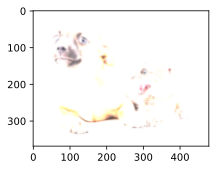

In [19]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

### Exercise: Initialize the final 2 layers of the FCN model
In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation. For a $1\times 1$ convolution layer, we use Xavier for random initialization.


In [20]:
### START CODE HERE ###
# Make a bilinear kernel with which to initialize the final transposed convolutional layer
# Remember, the number of input and output channels is the number of classes 
# and we want to enlarge the final images by a factor of 32
W = bilinear_kernel(in_channels=num_classes, out_channels=num_classes, kernel_size=64)
# Initialize the final layer with W
net[-1].initialize(init.Constant(W))
# Initialize the penultimate layer with the Xavier initialization
net[-2].initialize(init.Xavier())
### END CODE HERE ###

## Reading the Dataset

We read the dataset using the method described in the previous section. Here, we specify shape of the randomly cropped output image as $320\times 480$, so both the height and width are divisible by 32.


In [21]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


## Training

Now we can start training the model. The loss function and accuracy calculation here are not substantially different from those used in image classification. Because we use the channel of the transposed convolution layer to predict pixel categories, the `axis=1` (channel dimension) option is specified in `SoftmaxCrossEntropyLoss`. In addition, the model calculates the accuracy based on whether the prediction category of each pixel is correct.


loss 0.280, train acc 0.906, test acc 0.854
93.9 examples/sec on [gpu(0)]


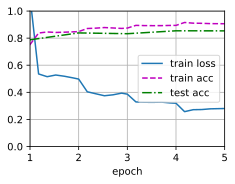

In [22]:
num_epochs, lr, wd, devices = 5, 0.1, 1e-3, d2l.try_all_gpus()
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(devices)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': lr, 'wd': wd})
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## Prediction

During predicting, we need to standardize the input image in each channel and transform them into the four-dimensional input format required by the convolutional neural network.


In [23]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = np.expand_dims(X.transpose(2, 0, 1), axis=0)
    pred = net(X.as_in_ctx(devices[0])).argmax(axis=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

To visualize the predicted categories for each pixel, we map the predicted categories back to their labeled colors in the dataset.


In [24]:
def label2image(pred):
    colormap = np.array(d2l.VOC_COLORMAP, ctx=devices[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

The size and shape of the images in the test dataset vary. Because the model uses a transposed convolution layer with a stride of 32, when the height or width of the input image is not divisible by 32, the height or width of the transposed convolution layer output deviates from the size of the input image. In order to solve this problem, we can crop multiple rectangular areas in the image with heights and widths as integer multiples of 32, and then perform forward computation on the pixels in these areas. When combined, these areas must completely cover the input image. When a pixel is covered by multiple areas, the average of the transposed convolution layer output in the forward computation of the different areas can be used as an input for the softmax operation to predict the category.

For the sake of simplicity, we only read a few large test images and crop an area with a shape of $320\times480$ from the top-left corner of the image. Only this area is used for prediction. For the input image, we print the cropped area first, then print the predicted result, and finally print the labeled category.


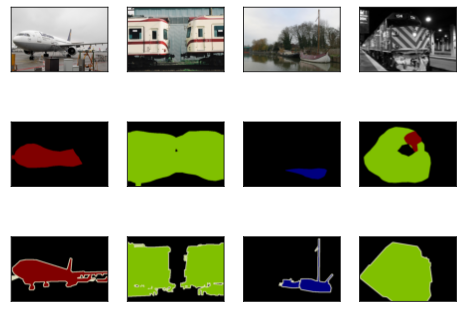

In [25]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## Summary

* The fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer to output the category of each pixel.
* In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation.